<a href="https://colab.research.google.com/github/brendanhasz/embedding-regression/blob/master/TFP_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MCMC and Variational Methods with Bayesian Models using Tensorflow Probability

intro...



>[MCMC and Variational Methods with Bayesian Models using Tensorflow Probability](#scrollTo=nwfwD2lsgp64)

>>[Data](#scrollTo=5Sl3oQAlVVYQ)

>>[Markov Chain Monte Carlo](#scrollTo=VeuCuk2zgPTx)

>>>[Model](#scrollTo=9cCxquAOP-Sp)

>>>[MCMC Sampling](#scrollTo=4T_pXKJbVPs1)

>>>[Posterior](#scrollTo=3LjFseDRiyfl)

>>>[Posterior Predictive Distribution](#scrollTo=vXRshfpUd_nc)

>>>[Prediction Distributions](#scrollTo=wVzQW2szmGUj)

>>[Variational Bayes](#scrollTo=AVYSmZ6exIlh)

>>>[Fitting the Variational Model](#scrollTo=Pd_WGG-ziII4)

>>>[Parameters and metrics over training](#scrollTo=EVct2VF8X9d3)

>>>[Posterior](#scrollTo=LbDLJkLAtGCY)

>>>[Posterior Predictive Distribution](#scrollTo=aNeZ_9cNiart)

>>>[Prediction Distributions](#scrollTo=e9ljOhywieDm)

>>[Comparing MCMC and Variational Fits](#scrollTo=q0VU7eLaagiu)

>>>[Posteriors](#scrollTo=E-aZrH4ni1TK)

>>>[Prediction Distributions](#scrollTo=TL8RbElNitoo)

>>[Conclusion](#scrollTo=2_LECAWfpeTm)



In [0]:
!pip install -q tfp-nightly

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import norm

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

np.random.seed(12345)
tf.set_random_seed(12345)
sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

##  Model

The model we'll use to generate the data is 

\begin{align*}
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{HalfNormal}(1) \\
\alpha &\sim \text{Normal}(0, 1) \\
y_i &\sim \text{Normal}(\alpha + x_i^\top \beta, ~ \sigma^2)
\end{align*}



## Data

In [0]:
# Generate fake data
D = 4
N = 100
noise_std_true = 1.0
w_true = np.random.randn(D, 1).astype(np.float32)
b_true = np.random.randn(1).astype(np.float32)
x = np.random.randn(N, D).astype(np.float32)
noise = noise_std_true * np.random.randn(N,1).astype(np.float32)
y = np.matmul(x, w_true) + b_true + noise

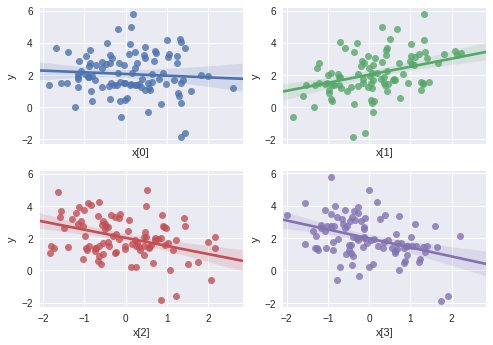

In [0]:
# Show data
plt.figure(figsize=[6.4,8])
fig, axes = plt.subplots(int(np.ceil(D/2)), 2, sharex=True)
for i in range(D):
  t_ax = axes[int(i/2), i%2] #this axis
  sns.regplot(x[:,i], y[:,0], ax=t_ax)
  t_ax.set_ylabel('y')
  t_ax.set_xlabel('x[%d]'%i)
plt.show()

## Markov Chain Monte Carlo

One way to fit bayesian models is using Markov chain monte carlo (MCMC) sampling. This is like stan etc

### Bayesian Model

A basic Bayesian linear regression.  The same model we used to generate the data.

\begin{align*}
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{HalfNormal}(1) \\
\alpha &\sim \text{Normal}(0, 1) \\
y_i &\sim \text{Normal}(\alpha + x_i^\top \beta, ~ \sigma^2)
\end{align*}



In [0]:
def linear_regression(features):
  """Bayesian linear regression, which returns predictions given features."""
  D = features.shape[1]
  coeffs = ed.Normal(        #normal prior on weights
      loc=tf.zeros([D,1]),
      scale=tf.ones([D,1]),
      name="coeffs")
  bias = ed.Normal(          #normal prior on bias
      loc=tf.zeros([1]), 
      scale=tf.ones([1]),
      name="bias") 
  noise_std = ed.HalfNormal( #half-normal prior on noise std
      scale=tf.ones([1]),
      name="noise_std")
  predictions = ed.Normal(   #normally-distributed noise around predicted values
      loc=tf.matmul(features, coeffs)+bias,
      scale=noise_std,
      name="predictions")
  return predictions

log_joint = ed.make_log_joint_fn(linear_regression)

def target_log_prob_fn(coeffs, bias, noise_std):
  """Target density."""
  return log_joint(
      features=x,
      coeffs=coeffs,
      bias=bias,
      noise_std=noise_std,
      predictions=y)

### MCMC Sampling

Yadda yadda

first let's make ourselves a little timer

In [0]:
class Timer:
  def __enter__(self):
    self.t0 = time.time()
  def __exit__(self, *args):
    print('Elapsed time: %0.2fs' % (time.time()-self.t0))

so that now we can time things:

In [0]:
with Timer():
  time.sleep(3.14)

Elapsed time: 3.14s


And then running the MCMC sampling,

In [0]:
# HMC Settings
num_results = int(10e3) #number of hmc iterations
n_burnin = int(5e3)     #number of burn-in steps
step_size = 0.05
num_leapfrog_steps = 2

# Parameter sizes
coeffs_size = [4,1]
bias_size = [1]
noise_std_size = [1]

# HMC transition kernel
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=step_size,
    num_leapfrog_steps=num_leapfrog_steps)

# Define the chain states
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=n_burnin,
    kernel=kernel,
    current_state=[
        tf.zeros(coeffs_size, name='init_coeffs'),
        tf.zeros(bias_size, name='init_bias'),
        tf.ones(noise_std_size, name='init_noise_std'),
    ])
coeffs, bias, noise_std = states

# Run the chain
with Timer(), tf.Session() as sess:
  [
      coeffs_,
      bias_,
      noise_std_,
      is_accepted_,
  ] = sess.run([
      coeffs,
      bias,
      noise_std,
      kernel_results.is_accepted,
  ])

# Samples after burn-in
coeffs_samples = coeffs_[n_burnin:,:,0]
bias_samples = bias_[n_burnin:]
noise_std_samples = noise_std_[n_burnin:]
accepted_samples = is_accepted_[n_burnin:]

Elapsed time: 6.08s


Talk about acceptance rate.  

Sounds like an acceptance rate of about 0.234 is "optimal".  http://dx.doi.org/10.1214/aoap/1034625254


In [0]:
print('Acceptance rate: ', np.mean(accepted_samples))

Acceptance rate:  0.9316


### Posterior

TODO: talk about looking @ posterior distribution

dist is the posterior, solid line is true val, dotted lines show 95% conf interval

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

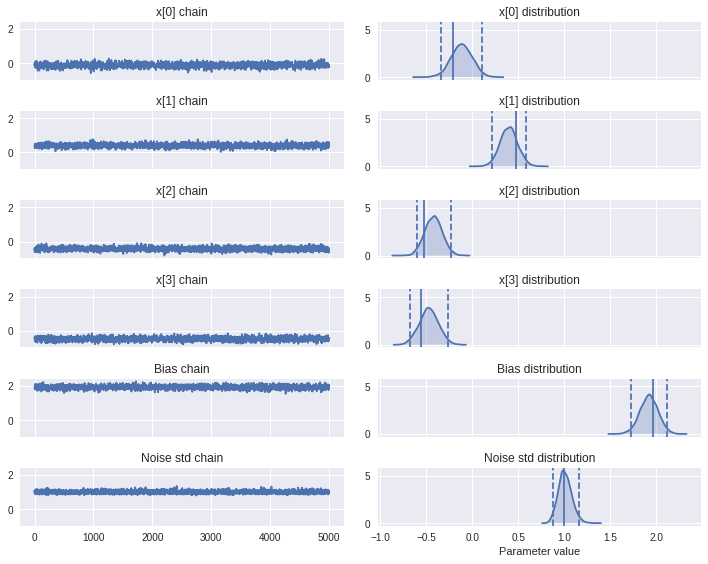

In [0]:
def chain_plot(data, title='', ax=None):
  '''Plot both chain and posterior distribution'''
  if ax is None:
    ax = plt.gca()
  ax.plot(data)
  ax.title.set_text(title+" chain")
  
def post_plot(data, title='', ax=None, true=None, prc=95):
  '''Plot the posterior distribution given MCMC samples'''
  if ax is None:
    ax = plt.gca()
  sns.kdeplot(data, ax=ax, shade=True)
  ax.axvline(x=np.percentile(data, (100-prc)/2), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-(100-prc)/2), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)
    
def chain_post_plot(data, title='', ax=None, true=None):
  '''Plot a chain of MCMC samples'''
  chain_plot(data, title=title, ax=ax[0])
  post_plot(data, title=title, ax=ax[1], true=true)
  
# Plot chains and distributions for coefficients
fig, axes = plt.subplots(D+2, 2, sharex='col', sharey='col')
fig.set_size_inches(10, 8)
for i in range(D):
  chain_post_plot(coeffs_samples[:,i],
                  title="x[{}]".format(i),
                  ax=axes[i], true=w_true[i])
  
# Plot chains and distributions for bias
chain_post_plot(bias_samples[:,0],
                title="Bias",
                ax=axes[D], true=b_true)

# Plot chains and distributions for noise std dev
chain_post_plot(noise_std_samples[:,0],
                title="Noise std",
                ax=axes[D+1], true=noise_std_true)
  
axes[D+1][1].set_xlabel("Parameter value")
fig.tight_layout()
plt.show()

### Posterior Predictive Distribution

TODO

talk math, how you set the param values to the mean of their posterior dists, and then sample from the model, you can see "posterior predictive distributions" (but this is assuming the true params = the mean of the posterior, which the prediction interval above didn't)

Only captures aleatoric (noise) uncertainty.

Generate some held-out data


In [0]:
# Generate held out data
N_val = 1000
x_val = np.random.randn(N_val, D).astype(np.float32)
noise = noise_std_true * np.random.randn(N_val, 1).astype(np.float32)
y_val = np.matmul(x_val, w_true) + b_true + noise

then intercept etc

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

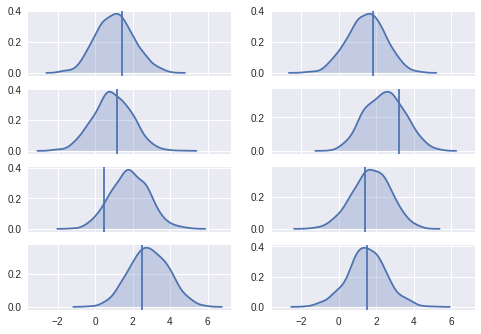

In [0]:
Nmc = 1000 #number of monte carlo draws

def interceptor(f, *args, **kwargs):
  name = kwargs.pop("name")
  if name == "coeffs":
    kwargs["value"] = np.reshape(np.mean(coeffs_samples, 0), (4,1))
  elif name == "bias":
    kwargs["value"] = np.mean(bias_samples, 0)
  elif name == "noise_std":
    kwargs["value"] = np.mean(noise_std_samples, 0)
  return f(*args, **kwargs)

with ed.interception(interceptor):
  posterior = linear_regression(features=x_val)

with tf.Session() as sess:
  posterior_predictive = sess.run(
      posterior.distribution.sample(sample_shape=(Nmc)))

# Plot random datapoints and their posterior predictive intervals
fig, axes = plt.subplots(4, 2, sharex='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    sns.kdeplot(posterior_predictive[:,ix,0], shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])
    vals1 = posterior_predictive[:,ix,0]

TODO: then you can take the mean of the posterior predictive for each datapoint and plot the residuals.  In theory the residual distribution should look like the distribution you used to model the noise (in our case a normal distribution)

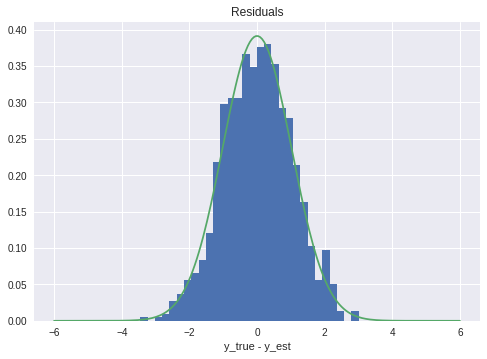

In [0]:
# Compute the mean posterior predictive for each datapoint
with tf.Session() as sess:
  y_pred = sess.run(
      posterior.distribution.mean())
  
# Plot the residual distribution
plt.figure()
residuals = y_val-y_pred
plt.hist(residuals, bins=30, density=True)
xx = np.linspace(-6, 6, 200)
plt.plot(xx, norm.pdf(xx, scale=np.std(residuals)))
plt.title('Residuals')
plt.xlabel('y_true - y_est')
plt.show()

Residuals look pretty good and match the noise distribution.

### Prediction Distributions


Talk about both epistemic (model) + aleatoric (noise) uncertainty. 

"Intercepting" the models at the posterior means captures only noise uncertainty, but this is a bayesian fit, so we have access to the model uncertainty as well!

TODO (generate prediction intervals for test data)

TODO: then also do it via intercepting (w/i a loop over all the MCMC samples). talk about how that's a pretty ineffecient way to do it, but not sure if there's a better way w/ tensorflow probability.

In [0]:
# Number of MCMC samples
Nmcmc = coeffs_samples.shape[0]

# Iterator through the MCMC samples
sample_iterator = iter(range(Nmcmc))

# Interceptor which uses a different MCMC sample's values each time
def interceptor(f, *args, **kwargs):
  ix = next(sample_iterator)
  name = kwargs.pop("name")
  if name == "coeffs":
    kwargs["value"] = np.reshape(coeffs_samples[ix,:], (4,1))
  elif name == "bias":
    kwargs["value"] = bias_samples[ix]
  elif name == "noise_std":
    kwargs["value"] = noise_std_samples[ix]
  return f(*args, **kwargs)

# Sample the prediction distribution for each MCMC sample
prediction_distribution = np.zeros((Nmcmc, N_val))
for i in range(Nmcmc):

  with ed.interception(interceptor):
    posterior = linear_regression(features=x_val)

  with tf.Session() as sess:
    prediction_distribution[i,:] = sess.run(posterior.distribution.sample())[:,0]

TODO: test the above works correctly...

While the above method might be easier with larger models, with this simple model it is almost easier to compute the prediction distributions directly from the MCMC samples and validation data by re-writing the model.  For larger models, however, re-writing the model would be tedious and error-prone.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

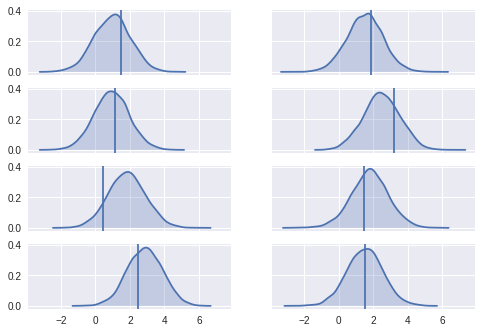

In [0]:
def ind_prediction_distribution(X):
  '''Compute the prediction distribution for an individual validation example'''
  predictions = np.matmul(X, coeffs_samples.transpose()) + bias_samples[:,0]
  noise = noise_std_samples[:,0]*np.random.randn(noise_std_samples.shape[0])
  return predictions + noise

# Compute prediction distribution for all validation samples
Nmcmc = coeffs_samples.shape[0]
prediction_distribution = np.zeros((N_val, Nmcmc))
for i in range(N_val):
  prediction_distribution[i,:] = ind_prediction_distribution(x_val[i,:])

# Plot random datapoints and their prediction intervals

fig, axes = plt.subplots(4, 2, sharex='all', sharey='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    pred_dist = prediction_distribution[ix,:]
    sns.kdeplot(pred_dist, shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])

coverage of the 95% interval!

In [0]:
# Compute proportion of estimates on validation data 
# which fall within the 95% prediction interval
q0 = 2.5
q1 = 97.5
within_conf_int = np.zeros(N_val)
for i in range(N_val):
  pred_dist = prediction_distribution[i,:]
  p0 = np.percentile(pred_dist, q0)
  p1 = np.percentile(pred_dist, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int[i] = 1

print('%0.1f %% of validation samples are w/i the %0.1f %% prediction interval' 
      % (100*np.mean(within_conf_int), q1-q0))

94.6 % of validation samples are w/i the 95.0 % prediction interval


Pretty well-calibrated!

But wait, how is this different from what we did before with the posterior predictive distribution?  

In [0]:
# Compute proportion of estimates on validation data 
# which fall within the 95% interval of the posterior predictive
q0 = 2.5
q1 = 97.5
within_conf_int = np.zeros(N_val)
for i in range(N_val):
  pred_dist = posterior_predictive[:,i,0]
  p0 = np.percentile(pred_dist, q0)
  p1 = np.percentile(pred_dist, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int[i] = 1

print('%0.1f %% of validation samples are w/i the %0.1f %% posterior predictive distribution' 
      % (100*np.mean(within_conf_int), q1-q0))

93.5 % of validation samples are w/i the 95.0 % posterior predictive distribution


that's because the posterior predictive distributions are slightly tighter than the prediction distributions. Why? Because the posterior predictive includes only aleatoric uncertainty (the irreducible uncertainty we built into our model by including a normally-distributed noise term).  The prediction distributions include not only aleatoric, but also epistemic uncertainty (our uncertainty as to the values of the model's parameters), and so these distributions are wider (more uncertain).

## Variational Bayes

cant do MCMC w/ full neural nets, would take too long, but can do variational! Talk about the upsides (fast) but also the downsides (assumes all params posteriors are independent)

We'll use a super-simple Bayesian neural network and ensure it comes up with the same uncertainty as the previous model which we fit with MCMC

TODO: net diagram

### Data Pipeline

For the variational model, we first need to set up a data pipeline. 
TODO: explain

In [0]:
def build_input_pipeline(x, y, x_val, y_val, batch_size, N_val):
  '''Build an Iterator switching between train and heldout data.
  Args:
    x: Numpy `array` of training features, indexed by the first dimension.
    y: Numpy `array` of training labels, with the same first dimension as `x`.
    x_val: Numpy `array` of validation features, indexed by the first dimension.
    y_val: Numpy `array` of validation labels, with the same first dimension as `x_val`.
    batch_size: Number of elements in each training batch.
    N_val: Number of examples in the validation dataset
  Returns:
    batch_features: `Tensor` feed  features, of shape
      `[batch_size] + x.shape[1:]`.
    batch_labels: `Tensor` feed of labels, of shape
      `[batch_size] + y.shape[1:]`.
  '''
  # Build an iterator over training batches.
  training_dataset = tf.data.Dataset.from_tensor_slices((x, y))
  training_batches = training_dataset.shuffle(
      50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
  train_iterator = training_batches.make_one_shot_iterator()

  # Build a iterator over the validation set with batch_size=N_val,
  # i.e., return the entire heldout set as a constant.
  val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  val_frozen = val_dataset.take(N_val).repeat().batch(N_val)
  val_iterator = val_frozen.make_one_shot_iterator()

  # Combine these into a feedable iterator that can switch between training
  # and validation inputs.
  handle = tf.placeholder(tf.string, shape=[])
  feedable_iterator = tf.data.Iterator.from_string_handle(
      handle, training_batches.output_types, training_batches.output_shapes)
  batch_features, batch_labels = feedable_iterator.get_next()

  return batch_features, batch_labels, handle, train_iterator, val_iterator

# DEBUGGER: reset the graph so you can re-run
tf.reset_default_graph() 
  
# Settings
batch_size = 50
max_steps = 2000
learning_rate = 0.01

# Build input pipeline
x_vals, y_vals,  handle, training_iterator, validation_iterator = (
    build_input_pipeline(x, y, x_val, y_val, batch_size, N_val) )

### Variational Model

Now we can construct the variational model...

In [0]:
# A linear regression model: a Normal distribution
# parameterized by location from a single linear layer.
with tf.name_scope("linear_regression", values=[x_vals]):
  layer = tfp.layers.DenseFlipout(
      units=1, 
      activation=None,
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn())
  predictions = layer(x_vals)  
  noise_std = tf.get_variable("noise_std", initializer=tf.ones([1]))
  pred_distribution = tfd.Normal(loc=predictions, scale=noise_std)

### Fitting the Variational Model

TODO: explain below



In [0]:
# Compute the -ELBO as the loss, averaged over the batch size
neg_log_likelihood = -tf.reduce_mean(pred_distribution.log_prob(y_vals))
kl_div = sum(layer.losses) / N
elbo_loss = neg_log_likelihood + kl_div

# Mean squared error metric for evaluation
mse, mse_update_op = tf.metrics.mean_squared_error(
    labels=y_vals, predictions=predictions)

# Use ADAM optimizer w/ -ELBO loss
with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(elbo_loss)

# To store parameter values over training
weight_mean = layer.kernel_posterior.mean()[:,0]
weight_std = layer.kernel_posterior.stddev()[:,0]
bias_mean = layer.bias_posterior.mean()
bias_std = layer.bias_posterior.stddev()
weight_means = np.zeros((max_steps, D))
weight_stds = np.zeros((max_steps, D))
bias_means = np.zeros(max_steps)
bias_stds = np.zeros(max_steps)
noise_stds = np.zeros(max_steps)
mses = np.zeros(max_steps)
losses = np.zeros(max_steps)
pred_distribution_means = pred_distribution.mean()

# Initialization op
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# Run the training session
with tf.Session() as sess:
  sess.run(init_op)

  # Training loop
  train_handle = sess.run(training_iterator.string_handle())
  val_handle = sess.run(validation_iterator.string_handle())
  with Timer():
    for iS in range(max_steps):
      [
          _,
          _,
          mses[iS],
          losses[iS],
          weight_means[iS,:],
          weight_stds[iS,:],
          bias_means[iS],
          bias_stds[iS],
          noise_stds[iS]
      ] = sess.run([
          train_op,
          mse_update_op,
          mse,
          elbo_loss,
          weight_mean,
          weight_std,
          bias_mean,
          bias_std,
          noise_std
      ], feed_dict={handle: train_handle})

  # Draw samples from the posterior
  Nmc = 1500
  w_draw = layer.kernel_posterior.sample(Nmc)
  b_draw = layer.bias_posterior.sample(Nmc)
  w_post, b_post = sess.run([w_draw, b_draw])
  
  # Draw posterior predictive samples
  posterior_predictive_var = np.asarray([sess.run(pred_distribution_means, feed_dict={handle: val_handle}) for _ in range(Nmc)])
  #this might have to be:
  #posterior_predictive_var = np.asarray([sess.run((pred_distribution_means), feed_dict={handle: val_handle}) for _ in range(Nmc)])
  
  # Draw prediction distribution samples
  prediction_dist_var = sess.run((pred_distribution.sample(Nmc)), feed_dict={handle: val_handle})

/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Elapsed time: 2.68s


### Parameters and metrics over training

Let's visualize the posterior distributions which were computed using variational fit.

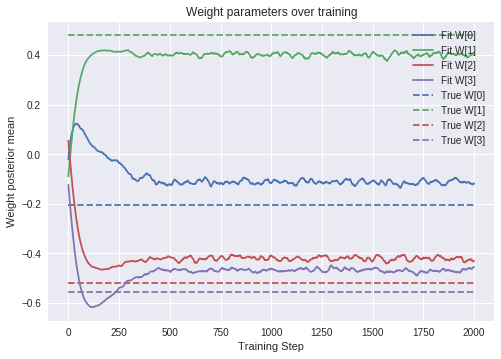

In [0]:
# Plot value of weights over training
plt.figure()
for iW in range(D):
  plt.plot(weight_means[:,iW], label='Fit W[{}]'.format(iW), 
           color=colors[iW])
  plt.hlines(w_true[iW], 0, max_steps, label='True W[{}]'.format(iW), 
             color=colors[iW], linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Weight posterior mean')
plt.title('Weight parameters over training')
plt.legend()
plt.show()

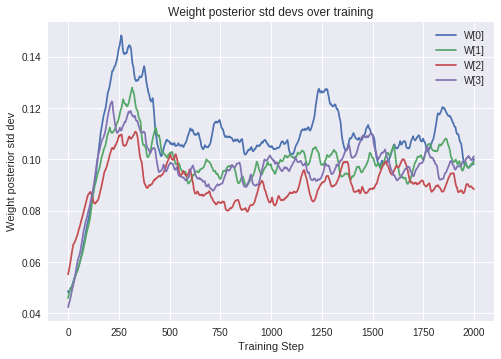

In [0]:
# Plot value of weight std devs over training
plt.figure()
for iW in range(D):
  plt.plot(weight_stds[:,iW], label='W[{}]'.format(iW), 
           color=colors[iW])
plt.xlabel('Training Step')
plt.ylabel('Weight posterior std dev')
plt.title('Weight posterior std devs over training')
plt.legend()
plt.show()

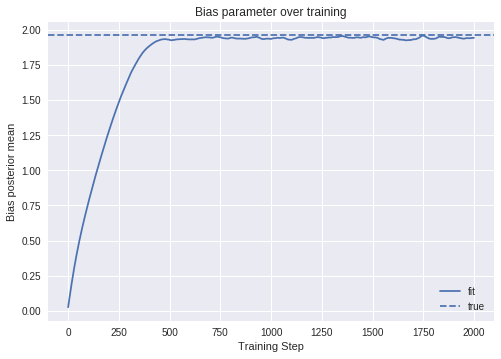

In [0]:
# Plot value of bias over training
plt.figure()
plt.plot(bias_means, label='fit')
plt.axhline(b_true, label='true', linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Bias posterior mean')
plt.title('Bias parameter over training')
plt.legend()
plt.show()

make sure the std dev doesn't shrink to 0 w/ more training?

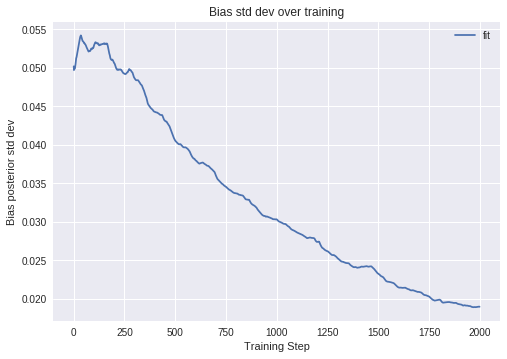

In [0]:
# Plot value of bias std dev over training
plt.figure()
plt.plot(bias_stds, label='fit')
plt.xlabel('Training Step')
plt.ylabel('Bias posterior std dev')
plt.title('Bias std dev over training')
plt.legend()
plt.show()

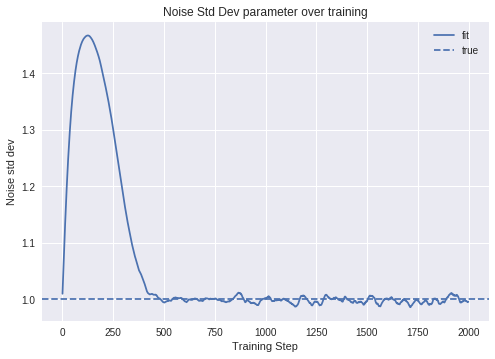

In [0]:
# Plot value of noise std dev over training
plt.figure()
plt.plot(noise_stds, label='fit')
plt.axhline(noise_std_true, label='true', linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Noise std dev')
plt.title('Noise Std Dev parameter over training')
plt.legend()
plt.show()

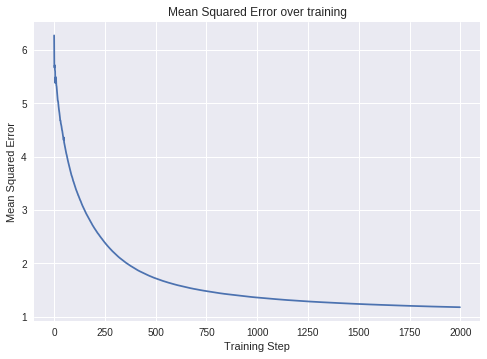

In [0]:
# Plot mean squared error over training
plt.figure()
plt.plot(mses[1:])
plt.xlabel('Training Step')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error over training')
plt.show()

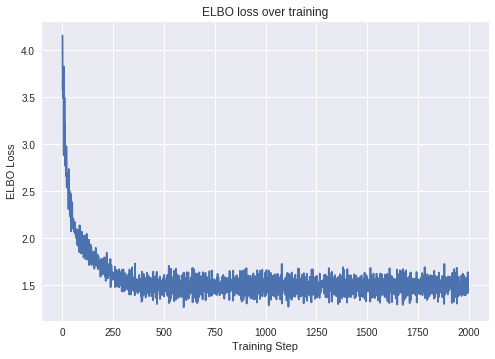

In [0]:
# Plot ELBO loss over training
plt.figure()
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('ELBO Loss')
plt.title('ELBO loss over training')
plt.show()

### Posterior

And we can also take a look at the posterior distributions for the weight and bias parameters (at the end of training).

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

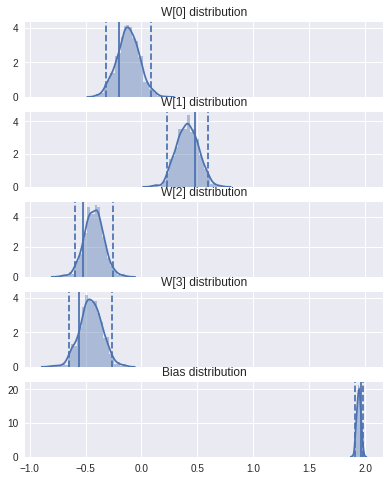

In [0]:
def post_plot(data, title='', ax=None, true=None, prc=95):
  if ax is None:
    ax = plt.gca()
  sns.distplot(data, ax=ax)
  ax.axvline(x=np.percentile(data, (100-prc)/2), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-(100-prc)/2), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)

# Plot weight posteriors
fig, axes = plt.subplots(D+1, 1, sharex=True)
fig.set_size_inches(6.4, 8)
for i in range(D):
  post_plot(w_post[:,i,0], title='W[{}]'.format(i), 
            ax=axes[i], true=w_true[i])
  
# Plot Bias posterior
post_plot(b_post[:,0], title='Bias', 
          ax=axes[D], true=b_true)
plt.show()

### Posterior Predictive Distribution
TODO


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

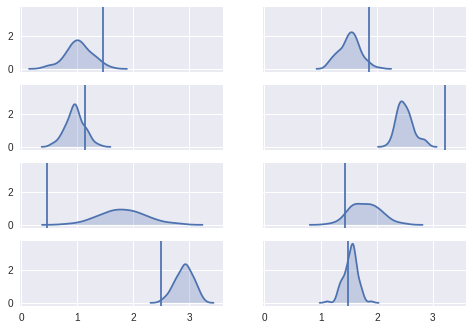

In [0]:
# Plot random datapoints and their posterior predictive distributions
fig, axes = plt.subplots(4, 2, sharex='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    pred_dist = posterior_predictive_var[:, ix, 0]
    sns.kdeplot(pred_dist, shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])

In [0]:
TODO: hmm those look wonky?

### Prediction Distributions

TODO

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

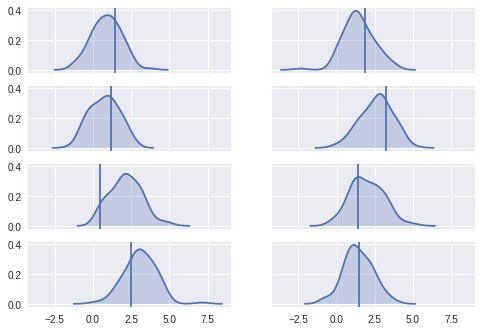

In [0]:
# Plot random datapoints and their prediction distributions
fig, axes = plt.subplots(4, 2, sharex='all', sharey='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    pred_dist = prediction_dist_var[:, ix, 0]
    sns.kdeplot(pred_dist, shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])

and can also look @ the coverage of the 95% conf interval for the variational model:

In [0]:
# Compute proportion of estimates on validation data 
# which fall within the 95% prediction interval
q0 = 2.5
q1 = 97.5
within_conf_int = np.zeros(N_val)
for i in range(N_val):
  pred_dist = prediction_dist_var[:, i, 0]
  p0 = np.percentile(pred_dist, q0)
  p1 = np.percentile(pred_dist, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int[i] = 1

print('%0.1f %% of validation samples are w/i the %0.1f %% prediction interval' 
      % (100*np.mean(within_conf_int), q1-q0))

92.6 % of validation samples are w/i the 95.0 % prediction interval


and again the 95% interval coverage is smaller for the posterior predictive distributions:

In [0]:
# Compute proportion of estimates on validation data 
# which fall within the 95% posterior predictive distribution
q0 = 2.5
q1 = 97.5
within_conf_int = np.zeros(N_val)
for i in range(N_val):
  pred_dist = posterior_predictive_var[:, i, 0]
  p0 = np.percentile(pred_dist, q0)
  p1 = np.percentile(pred_dist, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int[i] = 1

print('%0.1f %% of validation samples are w/i the %0.1f %% prediction interval' 
      % (100*np.mean(within_conf_int), q1-q0))

26.8 % of validation samples are w/i the 95.0 % prediction interval


In [0]:
TODO: hmm, is that percentage low?

(100, 1000, 1)

## Comparing MCMC and Variational Fits

TODO

### Posteriors

TODO: comparing the posteriors...

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

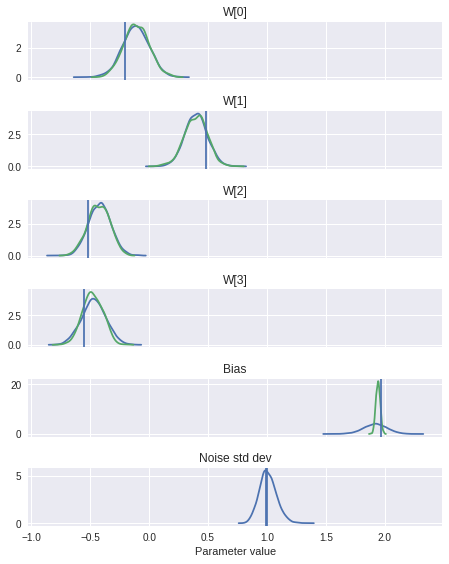

In [0]:
# Plot chains and distributions for coefficients
fig, axes = plt.subplots(D+2, 1, sharex='all')
fig.set_size_inches(6.4, 8)
for i in range(D):
  t_ax = axes[i]
  sns.kdeplot(coeffs_samples[:,i], ax=t_ax) #MCMC posterior
  sns.kdeplot(w_post[:,i,0], ax=t_ax) #variational posterior
  t_ax.axvline(x=w_true[i]) #true value
  t_ax.title.set_text('W[{}]'.format(i))
  
# Plot chains and distributions for bias
t_ax = axes[D]
sns.kdeplot(bias_samples[:,0], ax=t_ax) #MCMC posterior
sns.kdeplot(b_post[:,0], ax=t_ax) #variational posterior
t_ax.axvline(x=b_true) #true value
t_ax.title.set_text('Bias')

# Plot chains and distributions for noise std dev
t_ax = axes[D+1]
sns.kdeplot(noise_std_samples[:,0], ax=t_ax) #MCMC posterior
t_ax.axvline(x=noise_stds[-1]) #variational estimate
t_ax.axvline(x=noise_std_true) #true value
t_ax.title.set_text('Noise std dev')

axes[D+1].set_xlabel("Parameter value")
fig.tight_layout()
plt.show()

talk about how you used a point estimate for the std dev.  Not sure is what's causing the sharp estimate of the bias in the variational model

### Prediction Distributions 

TODO: compare the prediction distributions on individual points

In [0]:
# Plot some datapoints and their prediction distributions
# as computed by MCMC and variational Bayes
fig, axes = plt.subplots(4, 2, sharex='all', sharey='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    pred_dist_var = prediction_dist_var[:, ix, 0]
    pred_dist = prediction_distribution[ix,:]
    sns.kdeplot(pred_dist, shade=True, ax=axes[i][j])
    sns.kdeplot(pred_dist_var, shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])
    
TODO: LEGEND in plots comparing mcmc to variational

TODO: compare the coverage of the 95% intervals

In [0]:
# Compute proportion of estimates on validation data 
# which fall within the 95% prediction interval
q0 = 2.5
q1 = 97.5
within_conf_int = np.zeros(N_val)
within_conf_int_var = np.zeros(N_val)
for i in range(N_val):
  pred_dist = prediction_distribution[ix,:]  p0 = np.percentile(pred_dist, q0)
  p0 = np.percentile(pred_dist, q0)
  p1 = np.percentile(pred_dist, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int[i] = 1
    
  pred_dist_var = prediction_dist_var[:, ix, 0]
  p0 = np.percentile(pred_dist_var, q0)
  p1 = np.percentile(pred_dist_var, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int_var[i] = 1
    
print('%0.1f %% of validation samples are w/i the MCMC model %0.1f %% prediction interval' 
      % (100*np.mean(within_conf_int), q1-q0))
print('%0.1f %% of validation samples are w/i the variational model %0.1f %% prediction interval' 
      % (100*np.mean(within_conf_int_var), q1-q0))

TODO: calibration curve for both? conf interval goes from 0 -> 1, %in interval should lie along identiy line

## Conclusion

recap, advantages/disadvantages of each model (time, complexity)

talk about how TFP is such a new project and it's constantly evolving, wouldn't be suprised if much of the stuff in this post is outdated pretty quickly.

what else you can do, e.g. taxi data

Outline this notebook: 

- MCMC linear model
- Variational linear model ("simple neural net")


Next notebook:
- multi-layer neural net (but w/ constant noise term, use on taxi trip dataset and measure coverage of the 95% conf interval)
- 2 module multi-layer neural net (one to predict mean, other to predict variance), show how it can predict when noise increases in a simple heteroscedastic example, then use on taxi trip duration data! and see if it makes the coverage of the 95% conf interval closer to 95%!